# Klasifikasi Teks Kecelakaan Kerja Menggunakan Metode Multinomial Naive Bayes
---
## Deskripsi Singkat

Penelitian ini digunakan untuk mengklasifikasikan teks kecelakaan kerja menggunakan metode Multinomial Naive Bayes dengan dataset berupa teks berita kecelakaan kerja yang diperoleh dari situs web Detik. Data artikel berita kecelakaan kerja diklasifikasikan menjadi 8 kategori sesuai ketentuan International Labour Organization (ILO). Melalui penelitian ini diharapkan dapat memberikan wawasan yang lebih mendalam tentang klasifikasi teks kecelakaan kerja, serta membantu dalam analisis dan penanganan kejadian kecelakaan kerja di masa depan.

Dibuat oleh: Qorina Setyaningrum  
NIM: 200605110120

---


## Eksplorasi Data

### Import Library

In [1]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import pickle
from wordcloud import WordCloud
import os
from scipy import stats
from nltk.corpus import stopwords as nltk_stopwords
import nltk

# Unduh stopwords dari NLTK
nltk.download('stopwords')

# Membuat direktori untuk menyimpan file pickle dan CSV sementara
os.makedirs('pickle_files', exist_ok=True)
os.makedirs('intermediate_csv_files', exist_ok=True)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aljuh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import Dataset

In [2]:
from preprocess import preprocess_dataframe

# Memuat dataset
df = pd.read_csv("C:\\Code Qorina\\Model\\datasetfix.csv", encoding='ISO-8859-1')

# Menampilkan beberapa baris pertama dari dataset
df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aljuh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,tanggal,link,TeksBerita,Output
0,6/6/2023 22:39,https://news.detik.com/berita/d-6758894/pekerj...,Pekerja Tewas Terjatuh dari Lantai 7 di Jakpus...,Terjatuh
1,11/3/2020 20:07,https://news.detik.com/berita-jawa-timur/d-524...,Polisi Selidiki Penyebab Lift Anjlok dalam Pro...,Terjatuh
2,9/17/2020 11:30,https://news.detik.com/berita-jawa-timur/d-517...,"Kecelakaan Kerja Tewaskan 4 Orang, Polisi Pang...",Terjatuh
3,13 Agu 2020 04:17,https://news.detik.com/berita/d-5131024/cerita...,Cerita Saksi soal Tewasnya 4 Pekerja Tower Saa...,Terjatuh
4,6/2/2020 22:50,https://news.detik.com/berita/d-5038102/1-tewa...,1 Tewas-4 Luka-luka Saat Perbaiki Jembatan Bek...,Terjatuh


### Preprocessing Data

In [3]:
# Import necessary functions from preprocess.py
from preprocess import cleaning, case_folding, tokenize, remove_stopwords, stemming_text

# Updated preprocess_dataframe function
def preprocess_dataframe(df, text_column, label_column):
    df['Cleaning'] = df[text_column].apply(cleaning)
    df['CaseFolding'] = df['Cleaning'].apply(case_folding)
    df['Tokenize'] = df['CaseFolding'].apply(tokenize)
    df['Stemming'] = df['Tokenize'].apply(stemming_text)
    df['RemoveStopwords'] = df['Stemming'].apply(remove_stopwords)
    df['processed_text'] = df['RemoveStopwords'].apply(lambda tokens: ' '.join(tokens))
    return df[[text_column, label_column, 'Cleaning', 'CaseFolding', 'Tokenize', 'Stemming', 'RemoveStopwords', 'processed_text']]

# Preprocessing
df = preprocess_dataframe(df, 'TeksBerita', 'Output')

# Menyimpan data yang telah dipreproses dalam bentuk CSV dan pickle
df.to_csv('intermediate_csv_files/processed_dataframe.csv', index=False)
with open('pickle_files/processed_dataframe.pkl', 'wb') as f:
    pickle.dump(df, f)

# Menampilkan data yang telah dipreproses
df.head()


,TeksBerita,Output,Cleaning,CaseFolding,Tokenize,Stemming,RemoveStopwords,processed_text
0,Pekerja Tewas Terjatuh dari Lantai 7 di Jakpus...,Terjatuh,Pekerja Tewas Terjatuh dari Lantai di Jakpus O...,pekerja tewas terjatuh dari lantai di jakpus o...,"[pekerja, tewas, terjatuh, dari, lantai, di, j...","[kerja, tewas, jatuh, dari, lantai, di, jakpus...","[kerja, tewas, jatuh, lantai, jakpus, orang, l...",kerja tewas jatuh lantai jakpus orang luka ora...
1,Polisi Selidiki Penyebab Lift Anjlok dalam Pro...,Terjatuh,Polisi Selidiki Penyebab Lift Anjlok dalam Pro...,polisi selidiki penyebab lift anjlok dalam pro...,"[polisi, selidiki, penyebab, lift, anjlok, dal...","[polisi, selidik, sebab, lift, anjlok, dalam, ...","[polisi, selidik, lift, anjlok, proyek, bangun...",polisi selidik lift anjlok proyek bangun surab...
2,"Kecelakaan Kerja Tewaskan 4 Orang, Polisi Pang...",Terjatuh,Kecelakaan Kerja Tewaskan Orang Polisi Panggil...,kecelakaan kerja tewaskan orang polisi panggil...,"[kecelakaan, kerja, tewaskan, orang, polisi, p...","[celaka, kerja, tewas, orang, polisi, panggil,...","[celaka, kerja, tewas, orang, polisi, panggil,...",celaka kerja tewas orang polisi panggil yayasa...
3,Cerita Saksi soal Tewasnya 4 Pekerja Tower Saa...,Terjatuh,Cerita Saksi soal Tewasnya Pekerja Tower Saat ...,cerita saksi soal tewasnya pekerja tower saat ...,"[cerita, saksi, soal, tewasnya, pekerja, tower...","[cerita, saksi, soal, tewas, kerja, tower, saa...","[cerita, saksi, tewas, kerja, tower, bongkar, ...",cerita saksi tewas kerja tower bongkar sutet s...
4,1 Tewas-4 Luka-luka Saat Perbaiki Jembatan Bek...,Terjatuh,Tewas Lukaluka Saat Perbaiki Jembatan Bekas Ba...,tewas lukaluka saat perbaiki jembatan bekas ba...,"[tewas, lukaluka, saat, perbaiki, jembatan, be...","[tewas, lukaluka, saat, baik, jembatan, bekas,...","[tewas, lukaluka, jembatan, bekas, banjir, ban...",tewas lukaluka jembatan bekas banjir bandang s...


## Processing Data

### Model MNB Dengan Scikit Learn Library

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import normalize
import pickle

# Melakukan vektorisasi data teks
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df["processed_text"])

# Menyimpan hasil TF-IDF dalam bentuk DataFrame, CSV, dan pickle
tfidf_df = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df.to_csv('intermediate_csv_files/tfidf_dataframe.csv', index=False)
with open('pickle_files/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# Normalisasi nilai TF-IDF dengan norm='l2'
X_normalized = normalize(X, norm='l2', axis=1)

# Daftar rasio split yang akan diuji
split_ratios = [0.3, 0.2, 0.1]

# Evaluasi model untuk setiap rasio split
for ratio in split_ratios:
    test_size = ratio
    train_size = 1 - test_size
    
    # Membagi data menjadi data latih dan data uji
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, df["Output"], test_size=test_size, random_state=42)
    
    # Menyimpan data latih dan data uji dalam bentuk CSV dan pickle
    pd.DataFrame(X_train.toarray()).to_csv(f'intermediate_csv_files/X_train_{int(train_size*100)}_{int(test_size*100)}.csv', index=False)
    pd.DataFrame(X_test.toarray()).to_csv(f'intermediate_csv_files/X_test_{int(train_size*100)}_{int(test_size*100)}.csv', index=False)
    pd.DataFrame(y_train).to_csv(f'intermediate_csv_files/y_train_{int(train_size*100)}_{int(test_size*100)}.csv', index=False)
    pd.DataFrame(y_test).to_csv(f'intermediate_csv_files/y_test_{int(train_size*100)}_{int(test_size*100)}.csv', index=False)
    
    with open(f'pickle_files/X_train_{int(train_size*100)}_{int(test_size*100)}.pkl', 'wb') as f:
        pickle.dump(X_train, f)
    with open(f'pickle_files/X_test_{int(train_size*100)}_{int(test_size*100)}.pkl', 'wb') as f:
        pickle.dump(X_test, f)
    with open(f'pickle_files/y_train_{int(train_size*100)}_{int(test_size*100)}.pkl', 'wb') as f:
        pickle.dump(y_train, f)
    with open(f'pickle_files/y_test_{int(train_size*100)}_{int(test_size*100)}.pkl', 'wb') as f:
        pickle.dump(y_test, f)
    
    # Melatih model dengan Multinomial Naive Bayes dari sklearn
    model = MultinomialNB()
    model.fit(X_train, y_train)
    
    # Memprediksi hasil data uji
    y_pred = model.predict(X_test)
    
    # Memastikan panjang array sama
    if len(y_test) != len(y_pred):
        raise ValueError(f"Panjang y_test dan y_pred tidak sama! y_test: {len(y_test)}, y_pred: {len(y_pred)}")
    
    # Mengevaluasi model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Normalization: l2 - Train-Test Split Ratio: {int(train_size*100)}:{int(test_size*100)}")
    print(f"Accuracy: {accuracy:.2f}")
    print(report)
    print("="*50)
    print(f"Length of y_train: {len(y_train)}")
    print(f"Length of y_test: {len(y_test)}")

    # Menyimpan hasil prediksi dalam bentuk pickle
    with open(f'pickle_files/y_pred_{int(train_size*100)}_{int(test_size*100)}.pkl', 'wb') as f:
        pickle.dump(y_pred, f)

# Menyimpan model dalam bentuk pickle
with open('pickle_files/mnb_model.pkl', 'wb') as f:
    pickle.dump(model, f)


Normalization: l2 - Train-Test Split Ratio: 70:30
Accuracy: 0.81
                                                                    precision    recall  f1-score   support

                                        Kontak dengan Arus Listrik       1.00      1.00      1.00        36
                                           Melakukan Gerakan Berat       0.87      0.87      0.87        31
Menginjak, Menabrak, atau Tertimpa Benda, kecuali Benda yang Jatuh       0.64      0.88      0.74        33
                               Paparan/Kontak dengan Suhu Ekstrem        0.90      0.86      0.88        44
                  Paparan/Kontak dengan Zat atau Radiasi Berbahaya       0.89      0.84      0.86        38
                                                          Terjatuh       0.90      0.73      0.81        37
                   Terperangkap di dalam atau diantara benda-benda       0.83      0.51      0.63        39
                                        Tertimpa Benda-Benda Jatuh    

### Model MNB Tanpa Scikit Learn Library

In [5]:
import pickle
from sklearn.metrics import accuracy_score, classification_report
from mnb import MultinomialNaiveBayes
from sklearn.preprocessing import normalize

# Evaluasi model untuk setiap rasio split
split_ratios = [0.3, 0.2, 0.1]

for ratio in split_ratios:
    test_size = ratio
    train_size = 1 - test_size
    
    # Memuat data latih dan data uji dari file pickle
    with open(f'pickle_files/X_train_{int(train_size*100)}_{int(test_size*100)}.pkl', 'rb') as f:
        X_train = pickle.load(f)
    with open(f'pickle_files/X_test_{int(train_size*100)}_{int(test_size*100)}.pkl', 'rb') as f:
        X_test = pickle.load(f)
    with open(f'pickle_files/y_train_{int(train_size*100)}_{int(test_size*100)}.pkl', 'rb') as f:
        y_train = pickle.load(f)
    with open(f'pickle_files/y_test_{int(train_size*100)}_{int(test_size*100)}.pkl', 'rb') as f:
        y_test = pickle.load(f)
    
    # Normalisasi nilai TF-IDF dengan norm='l2'
    X_train_normalized = normalize(X_train, norm='l2', axis=1)
    X_test_normalized = normalize(X_test, norm='l2', axis=1)
    
    # Melatih model manual
    model_manual = MultinomialNaiveBayes()
    model_manual.fit(X_train_normalized.toarray(), y_train)
    
    # Memprediksi hasil test set
    y_pred_manual = model_manual.predict(X_test_normalized.toarray())
    
    # Memastikan panjang array sama
    if len(y_test) != len(y_pred_manual):
        raise ValueError(f"Panjang y_test dan y_pred_manual tidak sama! y_test: {len(y_test)}, y_pred_manual: {len(y_pred_manual)}")
    
    # Mengevaluasi model manual
    accuracy_manual = accuracy_score(y_test, y_pred_manual)
    report_manual = classification_report(y_test, y_pred_manual)
    
    print(f"Normalization: l2 - Train-Test Split Ratio: {int(train_size*100)}:{int(test_size*100)}")
    print(f"Manual Model Accuracy: {accuracy_manual:.2f}")
    print(report_manual)
    print("="*50)
    print(f"Length of y_train: {len(y_train)}")
    print(f"Length of y_test: {len(y_test)}")

    # Menyimpan hasil prediksi manual dalam bentuk pickle
    with open(f'pickle_files/y_pred_manual_{int(train_size*100)}_{int(test_size*100)}.pkl', 'wb') as f:
        pickle.dump(y_pred_manual, f)
    with open(f'pickle_files/y_test_manual_{int(train_size*100)}_{int(test_size*100)}.pkl', 'wb') as f:
        pickle.dump(y_test, f)

# Menyimpan model manual dalam bentuk pickle
with open('pickle_files/nb_model_manual.pkl', 'wb') as f:
    pickle.dump(model_manual, f)

Normalization: l2 - Train-Test Split Ratio: 70:30
Manual Model Accuracy: 0.81
                                                                    precision    recall  f1-score   support

                                        Kontak dengan Arus Listrik       1.00      1.00      1.00        36
                                           Melakukan Gerakan Berat       0.87      0.87      0.87        31
Menginjak, Menabrak, atau Tertimpa Benda, kecuali Benda yang Jatuh       0.64      0.88      0.74        33
                               Paparan/Kontak dengan Suhu Ekstrem        0.90      0.86      0.88        44
                  Paparan/Kontak dengan Zat atau Radiasi Berbahaya       0.89      0.84      0.86        38
                                                          Terjatuh       0.90      0.73      0.81        37
                   Terperangkap di dalam atau diantara benda-benda       0.83      0.51      0.63        39
                                        Tertimpa Benda-Be

### Visualisasi Hasil Prediksi Model MNB 

In [6]:
import pickle
import pandas as pd
from IPython.display import display

# Memuat DataFrame yang telah diproses
with open('pickle_files/processed_dataframe.pkl', 'rb') as f:
    df = pickle.load(f)

# Fungsi untuk membuat dan menampilkan tabel hasil prediksi
def create_results_table(df, y_test, y_pred):
    if len(y_test) != len(y_pred):
        raise ValueError("Panjang y_test dan y_pred tidak sama!")
    
    # Mengambil indeks asli dari y_test
    original_indices = y_test.index
    
    results_df = pd.DataFrame({
        'NO': original_indices,
        'True Label': y_test.values,
        'Predicted Label': y_pred
    })
    
    # Menghitung nilai TP, TN, FP, dan FN untuk setiap baris
    results_df['TP'] = ((results_df['True Label'] == results_df['Predicted Label']) & (results_df['True Label'] == results_df['True Label'])).astype(int)
    results_df['TN'] = ((results_df['True Label'] != results_df['True Label']) & (results_df['Predicted Label'] != results_df['True Label'])).astype(int)
    results_df['FP'] = ((results_df['True Label'] != results_df['True Label']) & (results_df['Predicted Label'] == results_df['True Label'])).astype(int)
    results_df['FN'] = ((results_df['True Label'] == results_df['True Label']) & (results_df['Predicted Label'] != results_df['True Label'])).astype(int)
    
    return results_df

# Skema pengujian
ratios = [0.3, 0.2, 0.1]
for test_size in ratios:
    train_size = 1 - test_size
    
    # Tabel hasil prediksi dengan library
    with open(f'pickle_files/y_test_{int(train_size*100)}_{int(test_size*100)}.pkl', 'rb') as f:
        y_test = pickle.load(f)
    with open(f'pickle_files/y_pred_{int(train_size*100)}_{int(test_size*100)}.pkl', 'rb') as f:
        y_pred = pickle.load(f)
    
    results_df_library = create_results_table(df, y_test, y_pred)
    
    print(f"Hasil Prediksi dengan Library (Rasio {int(train_size*100)}:{int(test_size*100)}):")
    display(results_df_library)
    
    # Menyimpan tabel ke dalam file CSV dan pickle
    results_df_library.to_csv(f'intermediate_csv_files/hasil_prediksi_library_{int(train_size*100)}_{int(test_size*100)}.csv', index=False)
    with open(f'pickle_files/hasil_prediksi_library_{int(train_size*100)}_{int(test_size*100)}.pkl', 'wb') as f:
        pickle.dump(results_df_library, f)
    
    # Tabel hasil prediksi manual
    with open(f'pickle_files/y_test_manual_{int(train_size*100)}_{int(test_size*100)}.pkl', 'rb') as f:
        y_test_manual = pickle.load(f)
    with open(f'pickle_files/y_pred_manual_{int(train_size*100)}_{int(test_size*100)}.pkl', 'rb') as f:
        y_pred_manual = pickle.load(f)
    
    results_df_manual = create_results_table(df, y_test_manual, y_pred_manual)
    
    print(f"Hasil Prediksi Manual (Rasio {int(train_size*100)}:{int(test_size*100)}):")
    display(results_df_manual)
    
    # Menyimpan tabel ke dalam file CSV dan pickle
    results_df_manual.to_csv(f'intermediate_csv_files/hasil_prediksi_manual_{int(train_size*100)}_{int(test_size*100)}.csv', index=False)
    with open(f'pickle_files/hasil_prediksi_manual_{int(train_size*100)}_{int(test_size*100)}.pkl', 'wb') as f:
        pickle.dump(results_df_manual, f)


Hasil Prediksi dengan Library (Rasio 70:30):


,NO,True Label,Predicted Label,TP,TN,FP,FN
0,836,Tertimpa Benda-Benda Jatuh,Tertimpa Benda-Benda Jatuh,1,0,0,0
1,477,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,1,0,0,0
2,350,Melakukan Gerakan Berat,Melakukan Gerakan Berat,1,0,0,0
3,893,"Menginjak, Menabrak, atau Tertimpa Benda, kecu...","Menginjak, Menabrak, atau Tertimpa Benda, kecu...",1,0,0,0
4,923,"Menginjak, Menabrak, atau Tertimpa Benda, kecu...","Menginjak, Menabrak, atau Tertimpa Benda, kecu...",1,0,0,0
...,...,...,...,...,...,...,...
283,501,Paparan/Kontak dengan Suhu Ekstrem,Paparan/Kontak dengan Suhu Ekstrem,1,0,0,0
284,796,Terperangkap di dalam atau diantara benda-benda,Terperangkap di dalam atau diantara benda-benda,1,0,0,0
285,634,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,1,0,0,0
286,405,Melakukan Gerakan Berat,Melakukan Gerakan Berat,1,0,0,0


Hasil Prediksi Manual (Rasio 70:30):


,NO,True Label,Predicted Label,TP,TN,FP,FN
0,836,Tertimpa Benda-Benda Jatuh,Tertimpa Benda-Benda Jatuh,1,0,0,0
1,477,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,1,0,0,0
2,350,Melakukan Gerakan Berat,Melakukan Gerakan Berat,1,0,0,0
3,893,"Menginjak, Menabrak, atau Tertimpa Benda, kecu...","Menginjak, Menabrak, atau Tertimpa Benda, kecu...",1,0,0,0
4,923,"Menginjak, Menabrak, atau Tertimpa Benda, kecu...","Menginjak, Menabrak, atau Tertimpa Benda, kecu...",1,0,0,0
...,...,...,...,...,...,...,...
283,501,Paparan/Kontak dengan Suhu Ekstrem,Paparan/Kontak dengan Suhu Ekstrem,1,0,0,0
284,796,Terperangkap di dalam atau diantara benda-benda,Terperangkap di dalam atau diantara benda-benda,1,0,0,0
285,634,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,1,0,0,0
286,405,Melakukan Gerakan Berat,Melakukan Gerakan Berat,1,0,0,0


Hasil Prediksi dengan Library (Rasio 80:20):


,NO,True Label,Predicted Label,TP,TN,FP,FN
0,836,Tertimpa Benda-Benda Jatuh,Tertimpa Benda-Benda Jatuh,1,0,0,0
1,477,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,1,0,0,0
2,350,Melakukan Gerakan Berat,Melakukan Gerakan Berat,1,0,0,0
3,893,"Menginjak, Menabrak, atau Tertimpa Benda, kecu...","Menginjak, Menabrak, atau Tertimpa Benda, kecu...",1,0,0,0
4,923,"Menginjak, Menabrak, atau Tertimpa Benda, kecu...","Menginjak, Menabrak, atau Tertimpa Benda, kecu...",1,0,0,0
...,...,...,...,...,...,...,...
187,462,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,1,0,0,0
188,673,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,Tertimpa Benda-Benda Jatuh,0,0,0,1
189,33,Terjatuh,Terjatuh,1,0,0,0
190,31,Terjatuh,Terjatuh,1,0,0,0


Hasil Prediksi Manual (Rasio 80:20):


,NO,True Label,Predicted Label,TP,TN,FP,FN
0,836,Tertimpa Benda-Benda Jatuh,Tertimpa Benda-Benda Jatuh,1,0,0,0
1,477,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,1,0,0,0
2,350,Melakukan Gerakan Berat,Melakukan Gerakan Berat,1,0,0,0
3,893,"Menginjak, Menabrak, atau Tertimpa Benda, kecu...","Menginjak, Menabrak, atau Tertimpa Benda, kecu...",1,0,0,0
4,923,"Menginjak, Menabrak, atau Tertimpa Benda, kecu...","Menginjak, Menabrak, atau Tertimpa Benda, kecu...",1,0,0,0
...,...,...,...,...,...,...,...
187,462,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,1,0,0,0
188,673,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,Tertimpa Benda-Benda Jatuh,0,0,0,1
189,33,Terjatuh,Terjatuh,1,0,0,0
190,31,Terjatuh,Terjatuh,1,0,0,0


Hasil Prediksi dengan Library (Rasio 90:10):


,NO,True Label,Predicted Label,TP,TN,FP,FN
0,836,Tertimpa Benda-Benda Jatuh,Tertimpa Benda-Benda Jatuh,1,0,0,0
1,477,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,1,0,0,0
2,350,Melakukan Gerakan Berat,Melakukan Gerakan Berat,1,0,0,0
3,893,"Menginjak, Menabrak, atau Tertimpa Benda, kecu...","Menginjak, Menabrak, atau Tertimpa Benda, kecu...",1,0,0,0
4,923,"Menginjak, Menabrak, atau Tertimpa Benda, kecu...","Menginjak, Menabrak, atau Tertimpa Benda, kecu...",1,0,0,0
...,...,...,...,...,...,...,...
91,814,Terjatuh,Terjatuh,1,0,0,0
92,518,Paparan/Kontak dengan Suhu Ekstrem,Paparan/Kontak dengan Suhu Ekstrem,1,0,0,0
93,770,Kontak dengan Arus Listrik,Kontak dengan Arus Listrik,1,0,0,0
94,286,Tertimpa Benda-Benda Jatuh,Tertimpa Benda-Benda Jatuh,1,0,0,0


Hasil Prediksi Manual (Rasio 90:10):


,NO,True Label,Predicted Label,TP,TN,FP,FN
0,836,Tertimpa Benda-Benda Jatuh,Tertimpa Benda-Benda Jatuh,1,0,0,0
1,477,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,Paparan/Kontak dengan Zat atau Radiasi Berbahaya,1,0,0,0
2,350,Melakukan Gerakan Berat,Melakukan Gerakan Berat,1,0,0,0
3,893,"Menginjak, Menabrak, atau Tertimpa Benda, kecu...","Menginjak, Menabrak, atau Tertimpa Benda, kecu...",1,0,0,0
4,923,"Menginjak, Menabrak, atau Tertimpa Benda, kecu...","Menginjak, Menabrak, atau Tertimpa Benda, kecu...",1,0,0,0
...,...,...,...,...,...,...,...
91,814,Terjatuh,Terjatuh,1,0,0,0
92,518,Paparan/Kontak dengan Suhu Ekstrem,Paparan/Kontak dengan Suhu Ekstrem,1,0,0,0
93,770,Kontak dengan Arus Listrik,Kontak dengan Arus Listrik,1,0,0,0
94,286,Tertimpa Benda-Benda Jatuh,Tertimpa Benda-Benda Jatuh,1,0,0,0


### K-Fold Cross Validation 10 Fold

In [7]:
import pickle
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from IPython.display import display, HTML

# Memuat DataFrame yang telah diproses
with open('pickle_files/processed_dataframe.pkl', 'rb') as f:
    df = pickle.load(f)

# Memuat vectorizer
with open('pickle_files/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

# Transformasi teks menggunakan TF-IDF vectorizer
X = tfidf_vectorizer.transform(df['processed_text'])
y = df['Output']

# Menggunakan K-Fold Cross-Validation dengan 10 fold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold = 1

# Menyimpan hasil untuk rata-rata
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

results = []

for train_index, test_index in kf.split(X):
    # Membagi data latih dan data uji berdasarkan fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Melatih model dengan Multinomial Naive Bayes dari sklearn
    model = MultinomialNB()
    model.fit(X_train, y_train)
    
    # Memprediksi hasil data uji
    y_pred = model.predict(X_test)
    
    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average='weighted') * 100
    recall = recall_score(y_test, y_pred, average='weighted') * 100
    f1 = f1_score(y_test, y_pred, average='weighted') * 100
    
    # Menyimpan metrik evaluasi untuk rata-rata
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    
    # Menyimpan hasil per iterasi
    results.append([fold, f"{accuracy:.2f}%", f"{precision:.2f}%", f"{recall:.2f}%", f"{f1:.2f}%"])
    
    fold += 1

# Menghitung rata-rata metrik evaluasi
average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
average_precision = sum(precision_scores) / len(precision_scores)
average_recall = sum(recall_scores) / len(recall_scores)
average_f1 = sum(f1_scores) / len(f1_scores)

# Menyimpan hasil rata-rata
results.append(["Rata-Rata", f"{average_accuracy:.2f}%", f"{average_precision:.2f}%", f"{average_recall:.2f}%", f"{average_f1:.2f}%"])

# Membuat DataFrame dari hasil
results_df = pd.DataFrame(results, columns=['Iterasi ke-', 'Akurasi', 'Presisi', 'Recall', 'F-1 Score'])

# Menampilkan hasil dalam format tabel dengan gaya yang lebih baik
styled_df = results_df.style.set_properties(**{
    'text-align': 'center',
    'font-size': '12px'
}).set_table_styles([{
    'selector': 'th',
    'props': [('font-size', '14px'), ('text-align', 'center'), ('background-color', '#f2f2f2')]
}
, {
    'selector': 'td, th',
    'props': [('border', '1px solid #ccc')]
}]).set_caption("Tabel Hasil K-Fold Cross-Validation")

# Menyimpan hasil ke dalam file CSV dan pickle
results_df.to_csv('intermediate_csv_files/kfold_results.csv', index=False)
with open('pickle_files/kfold_results.pkl', 'wb') as f:
    pickle.dump(results_df, f)

# Menampilkan hasil
print("Hasil K-Fold Cross-Validation:")
display(styled_df)

Hasil K-Fold Cross-Validation:


,Iterasi ke-,Akurasi,Presisi,Recall,F-1 Score
0,1,90.62%,91.62%,90.62%,90.52%
1,2,84.38%,85.82%,84.38%,84.52%
2,3,79.17%,83.55%,79.17%,79.60%
3,4,76.04%,78.82%,76.04%,75.94%
4,5,86.46%,89.64%,86.46%,86.95%
5,6,83.33%,86.23%,83.33%,83.37%
6,7,85.42%,87.36%,85.42%,85.91%
7,8,86.46%,87.14%,86.46%,86.16%
8,9,88.54%,90.67%,88.54%,88.86%
9,10,82.29%,84.06%,82.29%,82.38%


## Visualisasi Data

### Confusion Matrix

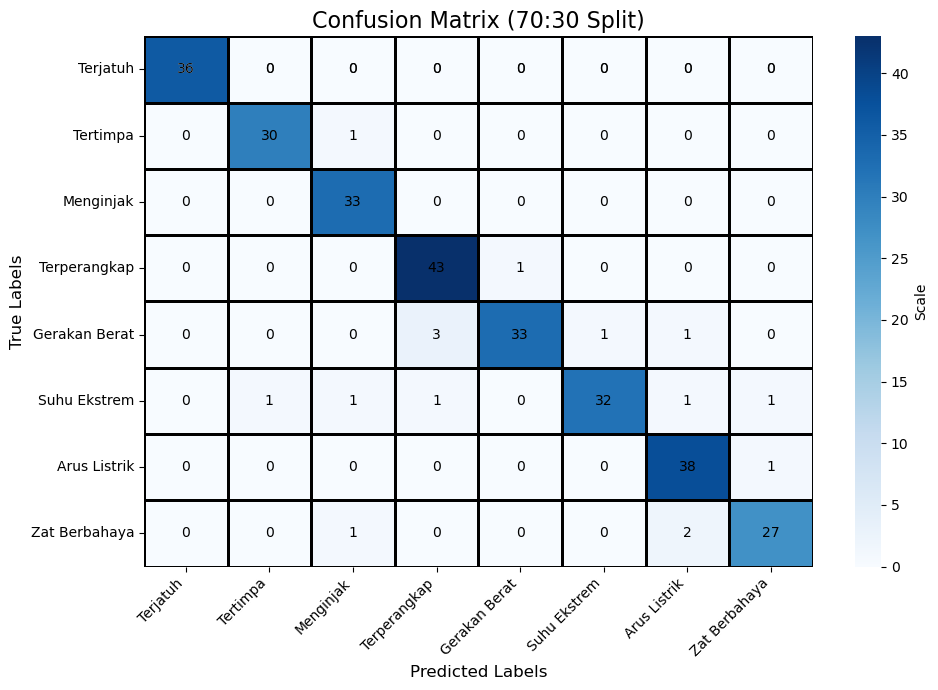

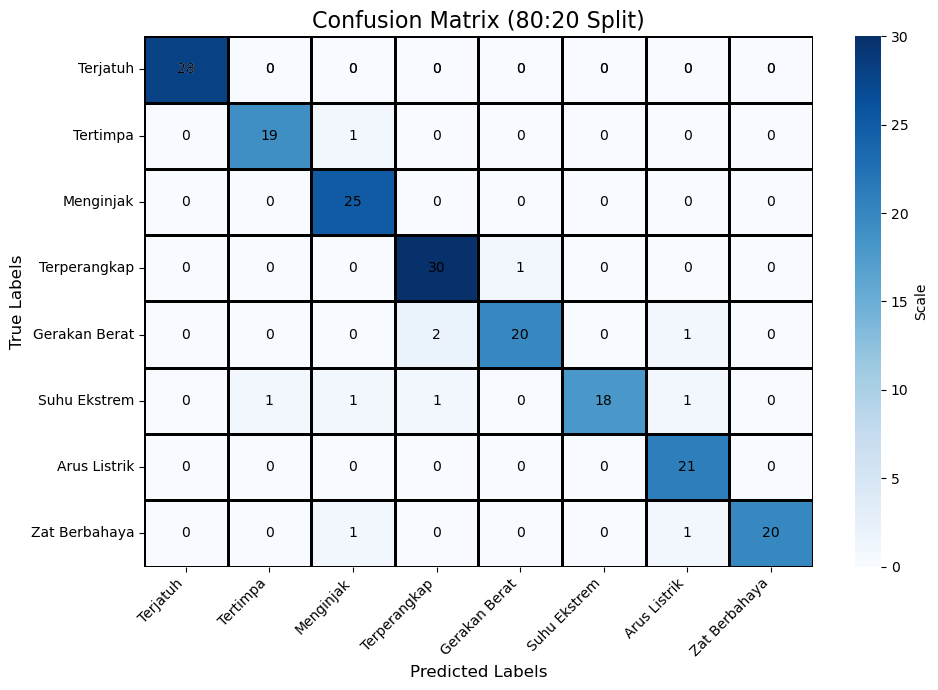

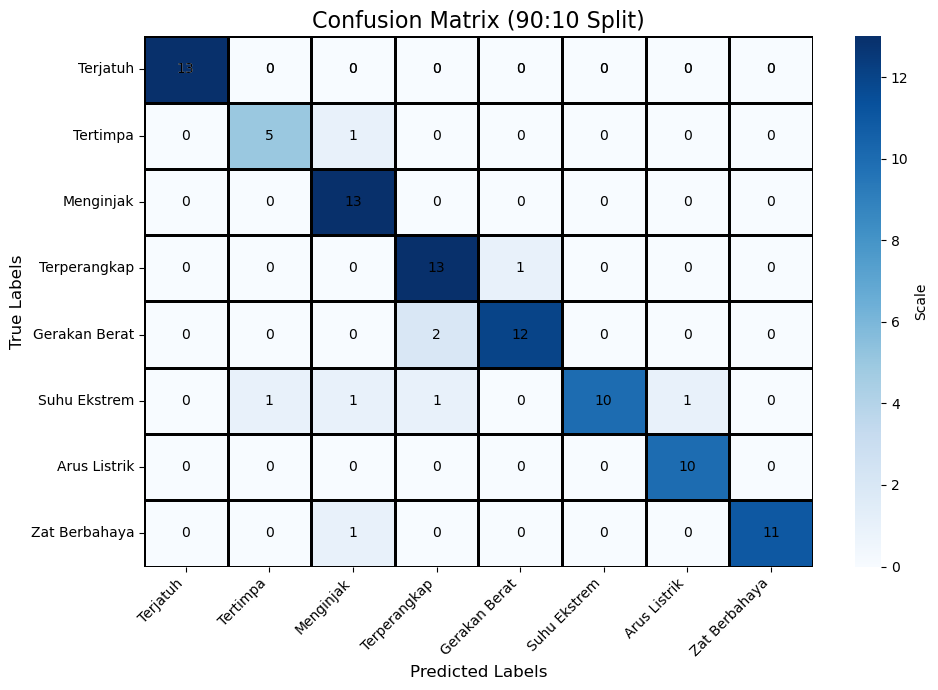

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

def annotator(data, ax, fmt="{:.0f}", zero_str="0"):
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            value = data[i, j]
            s = fmt.format(value) if value != 0 else zero_str  
            ax.text(j + 0.5, i + 0.5, s, va='center', ha='center', color="black")

# Memuat DataFrame yang telah diproses
with open('pickle_files/processed_dataframe.pkl', 'rb') as f:
    df = pickle.load(f)

# Memuat vectorizer
with open('pickle_files/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

# Memuat model
with open('pickle_files/mnb_model.pkl', 'rb') as f:
    model = pickle.load(f)

X = tfidf_vectorizer.transform(df['processed_text'])
y = df['Output']

splits = [(0.7, 0.3), (0.8, 0.2), (0.9, 0.1)]
cms = []

for train_size, test_size in splits:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    y_test_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)
    cms.append(cm)

class_labels = ['Terjatuh', 'Tertimpa', 'Menginjak', 'Terperangkap', 'Gerakan Berat', 'Suhu Ekstrem', 'Arus Listrik', 'Zat Berbahaya']
titles = ['70:30 Split', '80:20 Split', '90:10 Split']

for i, cm in enumerate(cms):
    plt.figure(figsize=(10, 7))
    ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=1, linecolor='black',
                     xticklabels=class_labels, yticklabels=class_labels, cbar_kws={'label': 'Scale'})
    plt.title(f'Confusion Matrix ({titles[i]})', fontsize=16)
    plt.ylabel('True Labels', fontsize=12)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    annotator(cm, ax, zero_str="0")
    plt.tight_layout()
    plt.show()

### Top 10 Kata Setiap Kelas dengan TF-IDF, Prior, Likehood, dan Posterior Value

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from IPython.display import display
import pickle

with open('pickle_files/processed_dataframe.pkl', 'rb') as f:
    df = pickle.load(f)

with open('pickle_files/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

X_tfidf = tfidf_vectorizer.transform(df['processed_text'])
X_tfidf_normalized = normalize(X_tfidf, norm='l2', axis=1)
features = tfidf_vectorizer.get_feature_names_out()
y = df['Output']

with open('pickle_files/mnb_model.pkl', 'rb') as f:
    model = pickle.load(f)

top_words = []

for class_label in y.unique():
    class_indices = (y == class_label)
    class_tfidf_sum = np.array(X_tfidf_normalized[class_indices].sum(axis=0)).flatten()
    class_tfidf_sum /= class_tfidf_sum.max()
    class_tfidf_sum = np.clip(class_tfidf_sum, 0, 0.999)
    word_freq = {features[j]: class_tfidf_sum[j] for j in range(class_tfidf_sum.shape[0])}
    sorted_word_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True)[:10])
    
    for word, tfidf_value in sorted_word_freq.items():
        word_index = np.where(features == word)[0][0]
        likelihood = np.exp(model.feature_log_prob_[list(y.unique()).index(class_label)][word_index])
        prior = np.exp(model.class_log_prior_[list(y.unique()).index(class_label)])
        posterior = prior * likelihood * tfidf_value
        top_words.append({
            "Class": class_label,
            "Word": word,
            "TF-IDF Value": tfidf_value,
            "Prior": prior,
            "Likelihood": likelihood,
            "Posterior": posterior
        })

top_words_df = pd.DataFrame(top_words)

def display_table(df):
    styled_df = df.style.format(precision=9) \
                        .set_table_styles({
                            'Word': [{'selector': 'td, th', 'props': [('text-align', 'center')]}],
                            'Class': [{'selector': 'td, th', 'props': [('text-align', 'center')]}],
                            'TF-IDF Value': [{'selector': 'td, th', 'props': [('text-align', 'center')]}],
                            'Prior': [{'selector': 'td, th', 'props': [('text-align', 'center')]}],
                            'Likelihood': [{'selector': 'td, th', 'props': [('text-align', 'center')]}],
                            'Posterior': [{'selector': 'td, th', 'props': [('text-align', 'center')]}]
                        }) \
                        .set_properties(**{'text-align': 'center'})
    display(styled_df)

display_table(top_words_df)

top_words_df.to_csv('intermediate_csv_files/top_words_per_class.csv', index=False)
with open('pickle_files/top_words_per_class.pkl', 'wb') as f:
    pickle.dump(top_words_df, f)


,Class,Word,TF-IDF Value,Prior,Likelihood,Posterior
0,Terjatuh,kerja,0.999000000,0.123842593,0.000245552,0.000030379
1,Terjatuh,jatuh,0.997182757,0.123842593,0.000126973,0.000015680
2,Terjatuh,korban,0.730220795,0.123842593,0.000746409,0.000067500
3,Terjatuh,lift,0.536543427,0.123842593,0.000062915,0.000004180
4,Terjatuh,tewas,0.452074960,0.123842593,0.000395780,0.000022158
5,Terjatuh,proyek,0.362591967,0.123842593,0.000125655,0.000005642
6,Terjatuh,bangun,0.360708809,0.123842593,0.000171896,0.000007679
7,Terjatuh,lantai,0.347913204,0.123842593,0.000125850,0.000005422
8,Terjatuh,celaka,0.336366097,0.123842593,0.000111014,0.000004624
9,Terjatuh,orang,0.318583974,0.123842593,0.000238860,0.000009424


### Word Cloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aljuh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


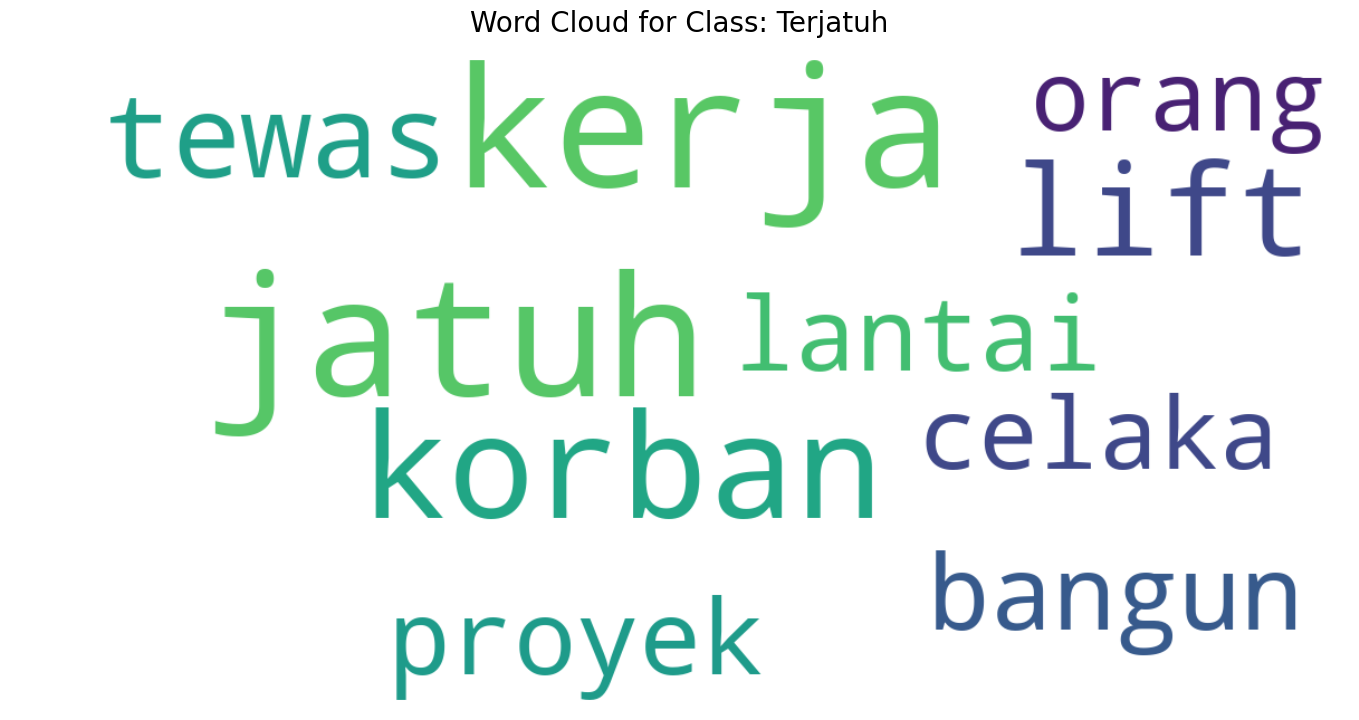

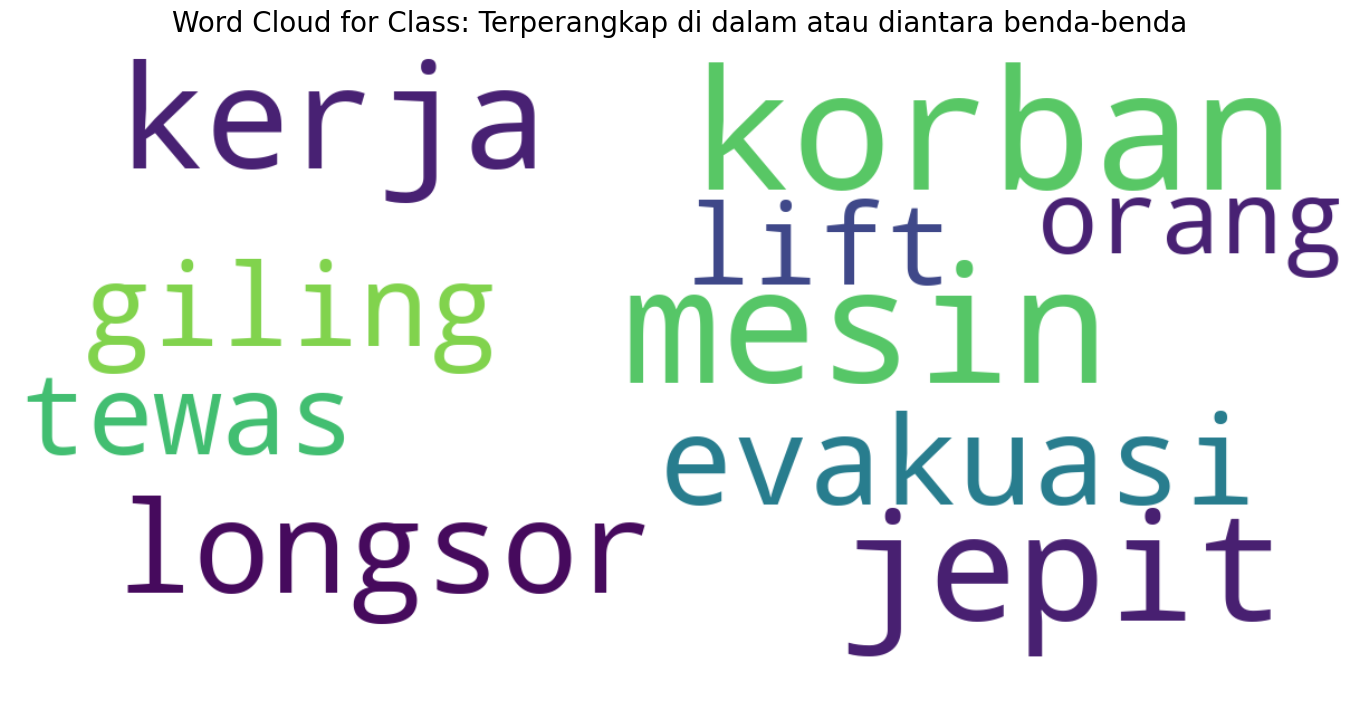

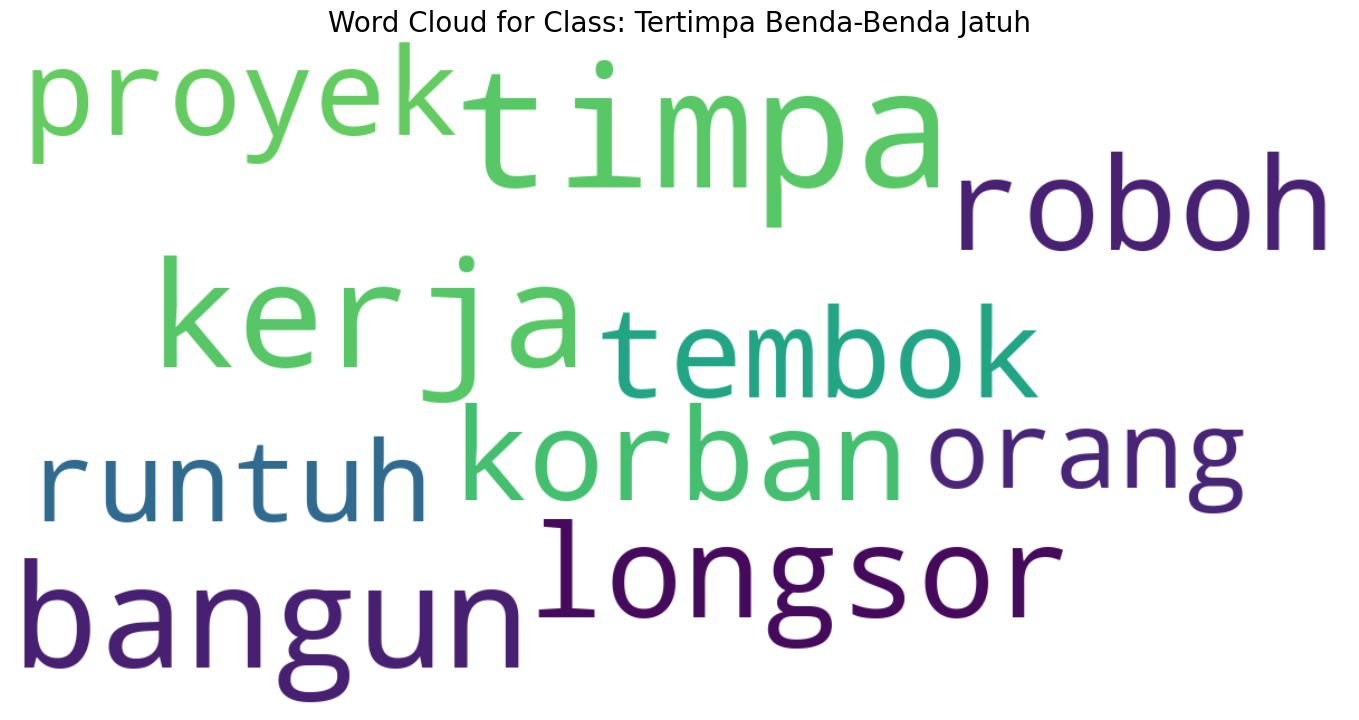

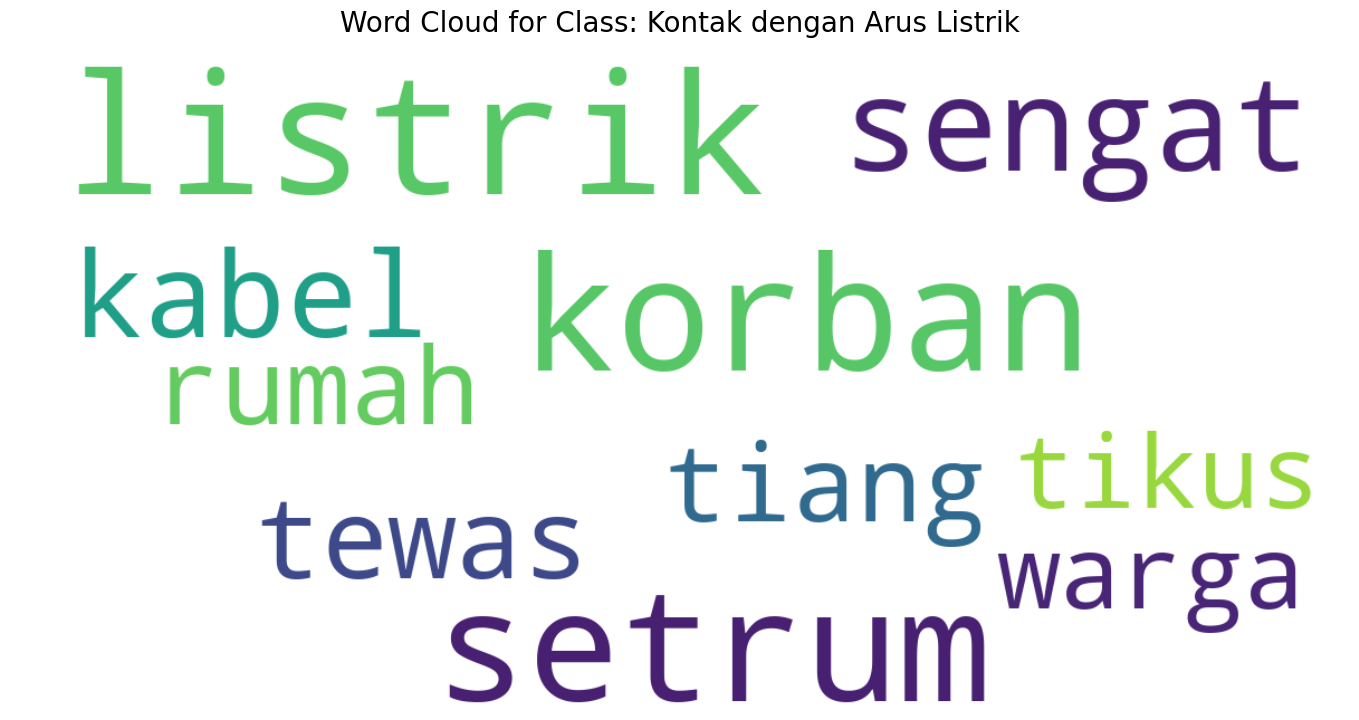

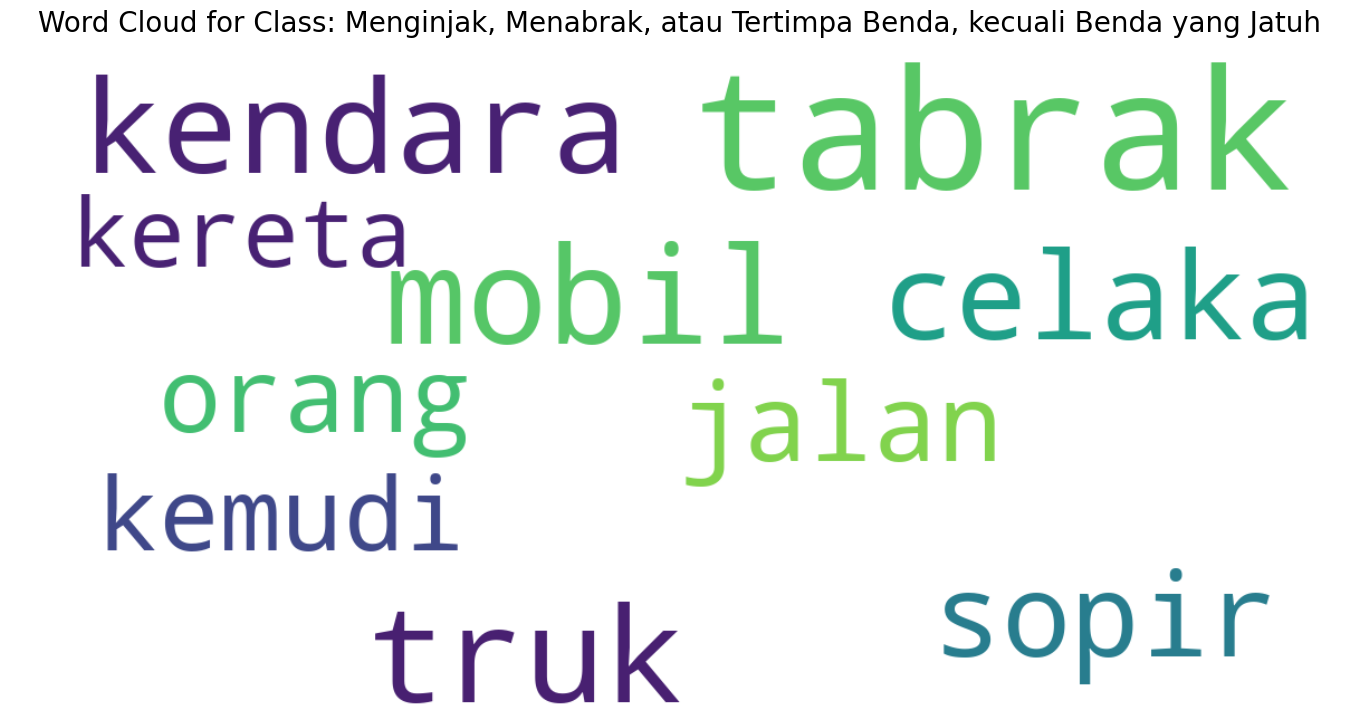

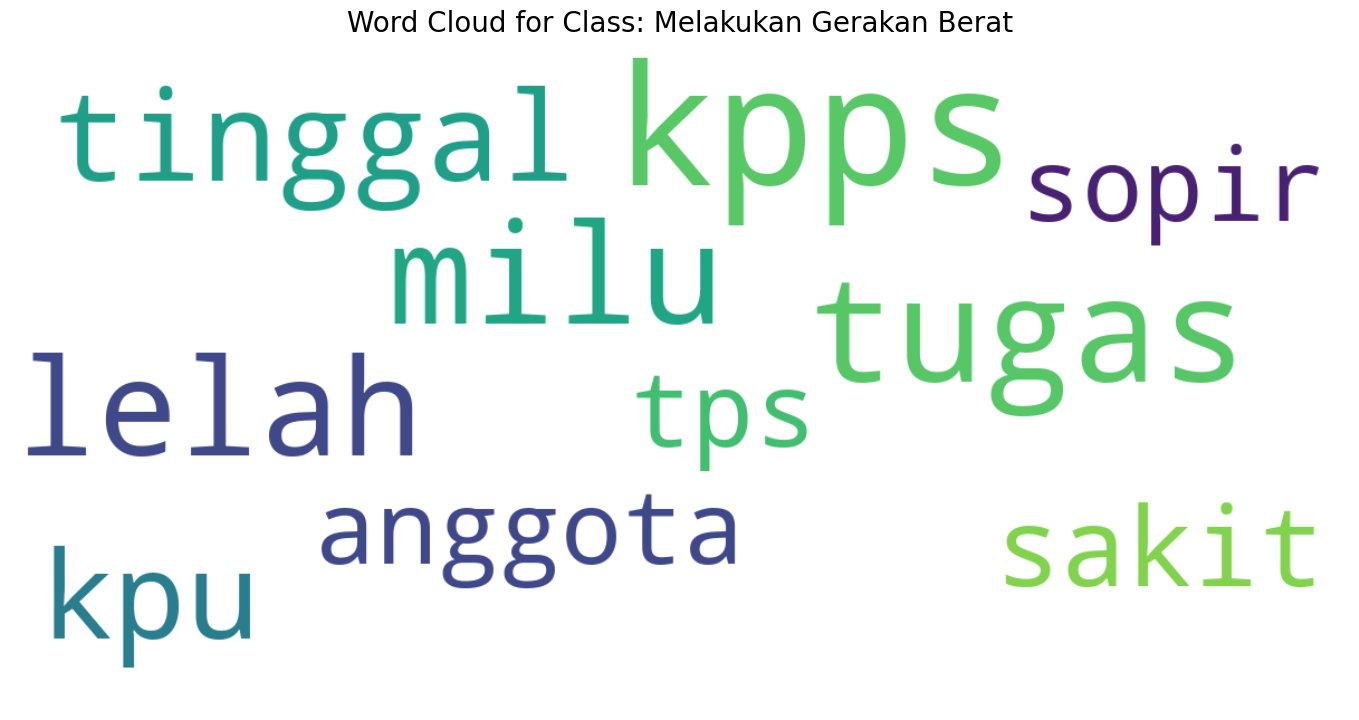

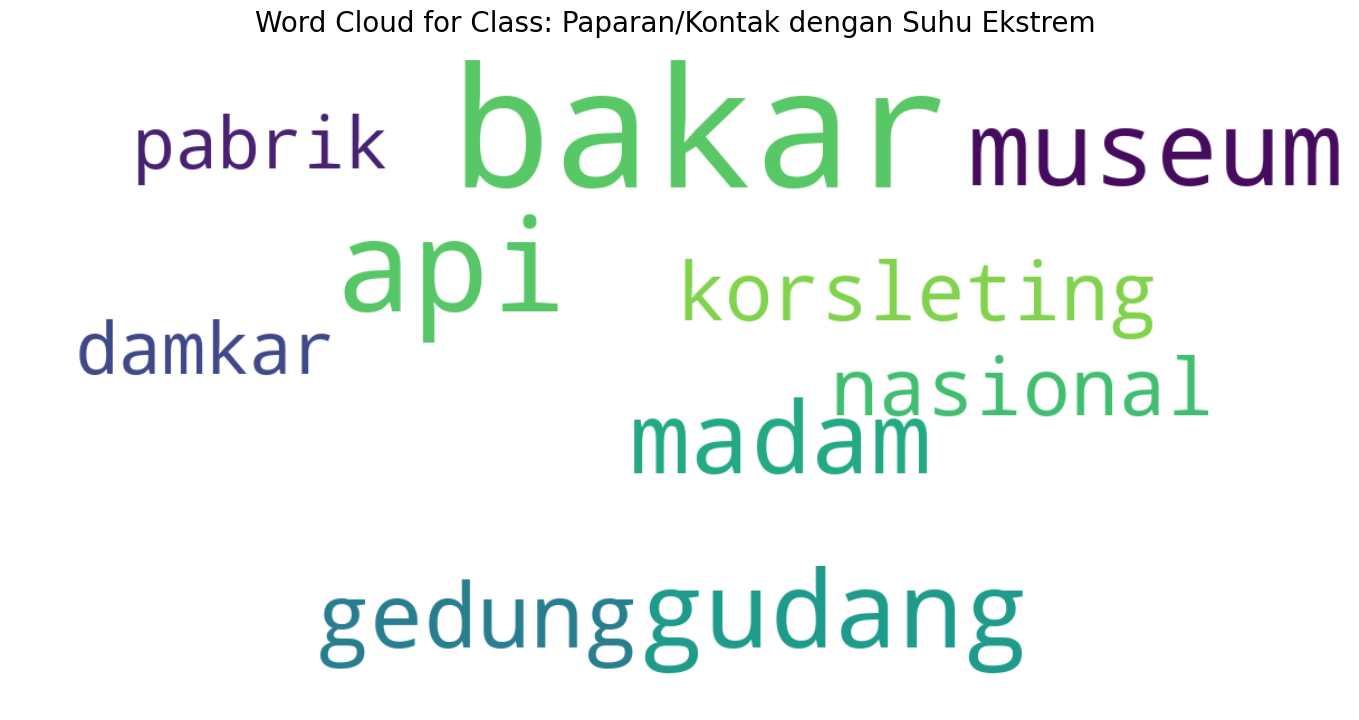

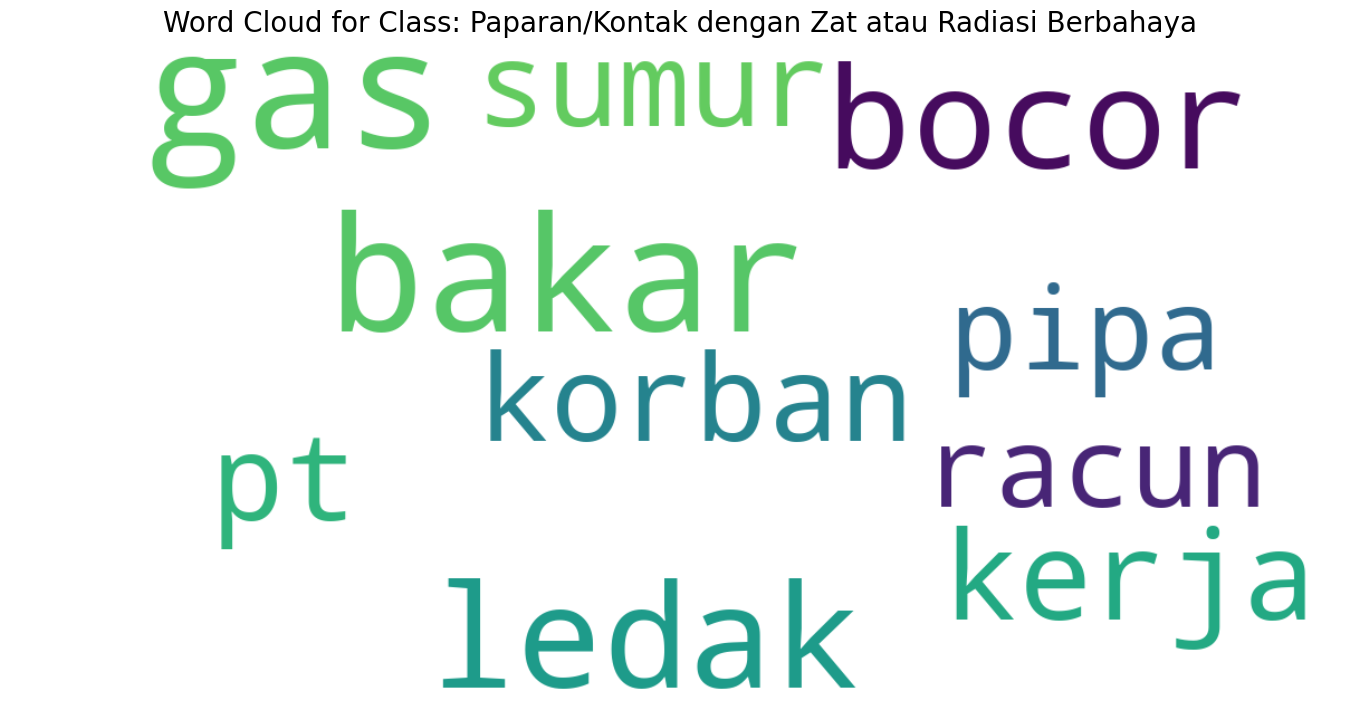

In [2]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from nltk.corpus import stopwords as nltk_stopwords
import nltk
import pickle

# Unduh stopwords dari NLTK
nltk.download('stopwords')

# Memuat DataFrame yang telah diproses
with open('pickle_files/processed_dataframe.pkl', 'rb') as f:
    df = pickle.load(f)

# Memuat vectorizer
with open('pickle_files/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

# Transformasi teks menggunakan TF-IDF vectorizer
X_tfidf = tfidf_vectorizer.transform(df['processed_text'])

# Ekstraksi fitur dan kelas dari DataFrame
features = tfidf_vectorizer.get_feature_names_out()
y = df['Output']

# Gabungkan STOPWORDS dari wordcloud dan NLTK
stopwords = set(STOPWORDS)
stopwords.update(nltk_stopwords.words('indonesian'))

# Tambahkan stopwords khusus
custom_stopwords = {'yang', 'untuk', 'dari', 'dengan', 'ada', 'ini', 'itu', 'dan', 'di'}
stopwords.update(custom_stopwords)

# Fungsi untuk membuat word cloud untuk setiap kelas
def generate_wordcloud(text, title=None):
    wordcloud = WordCloud(width=1200, height=600, background_color='white', 
                          stopwords=stopwords, colormap='viridis', 
                          max_font_size=150, random_state=42, max_words=10).generate_from_frequencies(text)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=20)
    plt.tight_layout(pad=0)
    plt.show()

# Membuat word cloud untuk setiap kelas
for class_label in y.unique():
    # Pilih baris yang sesuai dengan kelas
    class_indices = (y == class_label)
    
    # Jumlahkan nilai TF-IDF untuk kelas
    class_tfidf_sum = X_tfidf[class_indices].sum(axis=0)
    
    # Buat dictionary frekuensi kata, kecuali stopwords
    word_freq = {features[j]: class_tfidf_sum[0, j] for j in range(class_tfidf_sum.shape[1]) if features[j] not in stopwords}
    
    # Urutkan dictionary berdasarkan frekuensi dan pilih 20 kata teratas
    sorted_word_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True)[:20])
    
    # Membuat word cloud
    generate_wordcloud(sorted_word_freq, title=f'Word Cloud for Class: {class_label}')


# Format Projek

In [ ]:
import nbformat

# Memuat notebook
notebook_path = 'C:\\Code Qorina\\Model\\SkripsiQorina.ipynb'
with open(notebook_path, 'r', encoding='utf-8') as f:
    notebook = nbformat.read(f, as_version=4)

# Mengekstrak dan mencetak sel kode
code_cells = [cell for cell in notebook.cells if cell.cell_type == 'code']

# Mencetak konten dari sel kode untuk memahami konteks
for i, cell in enumerate(code_cells):
    print(f"Cell {i}:\n{cell.source}\n")